# **Chap8：图神经网络GNN**

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from source.code import ch8
from source.code import utils 
import os
import time

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=2)

## **8.1 图任务和GNN**

### **8.1.1 图数据和图任务**

除了图像和文本之外，另外一种随着互联网技术发展成熟起来，不断扩展和丰富的**非结构化**数据是**图数据**（**Graph Data**），图数据主要**由节点（样本个体）、边（个体间的连接关系），及节点上的特征和边上的特征组成**，例如：
* 在一个通信软件 / 平台上（微信、支付宝、通讯录），每个用户视为节点，好友关系视为边，这就构成了最简单的好友图网络
* 在社交媒体平台上，每个用户可以视为节点，**A 关注 B 可以视为从 A 到 B 的有向边**，这构成了一个带方向的社交图网络
* 在论文数据集中，每一篇论文可以视为节点，**论文间的引用关系可以视为边**，这构成了一个论文引用关系图网络

在很多机器学习建模问题中，**物以类聚，人以群分**的思想普遍通用，**图数据就为我们提供了一种天然的聚集结构**，借助图的结构，我们能够从这些连接关系中挖掘出更多有价值的信息
* 例如**欺诈团伙经常有转账交易**，以转账关系建立起来的图网络能够整体挖掘出欺诈团伙，**这比单独依据每个欺诈个体的特征来识别黑户会更加有效**

我们首先介绍图数据的分类和构成，然后介绍有关于图数据的几种常见的目标任务

#### **8.1.1.1 图数据**

**(1) 静态同构图**

<img src="../source/Chap8/静态同构图.png" width=250>

静态同构图是最常见，最简单的一种图数据，我们用 $\mathcal{G}=\{\mathcal{N}, \mathcal{E}, \mathcal{N}_f, \mathcal{E}_f\}$ 表示图数据，其中：
* $\mathcal{N}$ 表示节点集合，例如 $\mathcal{N} = \{n_1,n_2,\cdots,n_N\}$，在**同构图中，我们要求所有的节点属于同一类型实体**
  * 图中连接关系多样，在有的图中，可能是不同类型的两个实体具有连接关系，例如**银行-个人**，**学校-学生**等，在这些连接关系中，涉及到两种及以上不同类型实体的连接关系，**这不是同构图所考虑的范畴**，同构图要求所有节点都可以抽象为同一类型的实体
* $\mathcal{E}$ 表示边集合，边集合**可以用邻接矩阵或哈希表**来存储
  * 如果图**边的连接比较稠密**，则使用 0-1 的邻接矩阵是个不错的选择
    ```python
    # 使用 01 邻接矩阵
    edges = [[0, 0, 1, 1, 0, 1],
             [0, 0, 1, 0, 1, 1],
             [1, 1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0, 1],
             [0, 1, 0, 0, 0, 1],
             [1, 1, 0, 1, 1, 0]]
    ```
  * 如果图**边的链接比较稀疏**，则**使用哈希表存储每个节点的邻居节点可以节省内存空间**：
    ```python
    # 使用哈希表
    edges = {
      0: [2, 3, 5],
      1: [2, 4, 5],
      2: [0, 1],
      3: [0, 5],
      4: [1, 5],
      5: [0, 1, 3, 4]
    }
* $\mathcal{N}_f$ 表示**节点特征**，每个节点 $n_i$ 可以拥有自己的一组特征 $n_i^{(f)}\in\mathbb{R}^{p}$
  * 例如在社交图中，每个账户作为节点，则账户个体的年龄、性别、注册时长、活跃度等信息就可以作为节点特征
  * 例如在论文引用图中，每篇论文作为节点，则论文的字数、学科类别、发表期刊、发表年份等信息可以作为节点特征
* $\mathcal{E}_f$ 表示**边特征**，每条图中存在的边 $e_{i,j}\in\mathcal{E}$ 可以拥有自己的一组特征 $e_{i,j}^{(f)}\in\mathbb{R}^q$
  * 例如在社交图中，用户 A 关注 B 成为一条边，则 A 对 B 的评论数、点赞数、转发数等信息可以作为边特征
  * 例如在微信 / 支付宝好友网络图中，A 和 B 之间的转账次数、转账金额等信息就可以作为边特征

**(2) 静态异构图**

<img src="../source/Chap8/静态异构图.png" width=300>

如果**解除同构图中对节点属于同一类型实体的限制**，我们就得到了**异构图**，此时**节点集合可以根据实体类型划分为多个组** $\mathcal{N} = \mathcal{N}_1 \cup \mathcal{N}_2\cup\cdots\cup \mathcal{N}_k$
* 例如在**公司-员工**图网络中，所有公司可以构成节点集合 $\mathcal{N}_1$，所有员工构成节点集合 $\mathcal{N_2}$
  * 根据**任职关系**，**员工先与自己所在的公司相连**
  * 根据**公司的合作关系 / 投资关系**，公司之间又可以相连
* 由于节点类型不同，异构图中，**不同类型的节点可以拥有不同类型的特征**，同样，不同类型节点之间的连接边特征也可以有不同的表示
  * 例如员工作为节点有属于自己的特征向量（例如员工年龄，性别），公司节点有另一套特征向量（例如公司规模、公司人数、公司类型）
  * 员工与公司连接的边特征（例如工资，职级），和公司之间的边征也可以使用不同含义的特征向量（例如投资金额、合作类型）

**(3) 动态图**

<img src="../source/Chap8/动态图.png" width=900>

在更复杂的场景中，**图上的信息会随着时间发生变化**，此时我们就需要引入动态图 $\mathcal{G}(t)=\{\mathcal{N}(t), \mathcal{E}(t), \mathcal{N}_f(t), \mathcal{E}_f(t)\}$
* 通常，我们会选择某一**观察时间点** $t$ 及**时间窗口** $T$，**统计过去一段时间以来所有连接关系构成的图** $\mathcal{G}(t)$
  * 这可以称为在时间 $t$ 时，**图结构的一个快照** $\mathcal{G}(t)$
  * 例如在社交平台中，我们可以**按周 / 月的频率来构建每周 / 每月的社交图网络**，即统计过去一周 / 一个月用户的关注、点赞、转发、评论等数据的汇总信息，构建出当前观察时间的图网络
* 动态图能够**捕获图结构中的变化趋势，趋势信息的加入能够进一步从数据中挖掘有效信息**
  * 例如欺诈团伙时别中，我们能够在动态图中捕捉到欺诈团伙的状大，资金流的规模和广度增大成为交易网络中的异常点，这些趋势可以被模型抓取

最后，我们简单说明图数据中**跳数**和**k-跳**的概念
* **与节点直接相连**的邻居被称为 **1-跳** 邻居节点
* 间接相连的节点需要大于 1 次跳跃才能建立连接关系，**k-跳** 即指需要至少 $k$ 次跳跃才能建立连接
* 如果节点 $A$ 到节点 $B$ 有多条路径可达，则**取最短路径长度作为** $A,B$ **之间的跳数**

在后续大部分的讨论中，我们只考虑**1-跳问题**，即**只考虑与节点直接相连的邻居**

#### **8.1.1.2 图任务**

图数据的预测任务大致可以分为**节点级任务**，**边级任务**和**全局图任务**三类

**(1) 节点级任务**

节点级任务是最常见最广泛的一类图预测任务，我们需要借助图的信息，提升模型对每个节点个体的预测准确度，即对节点集合 $\mathcal{N}$ 中的每个节点 $n_i$ 做出判别
* 例如在欺诈团伙识别中，我们需要判断每个个体账户是否是黑户，这是一个 **0-1 二分类问题**
* 在物流图网络中，我们可能需要预测每个城市节点的流量，这是一个**回归问题**
* 有时候我们面对的是**无标签的图结构数据**，但我们可以**通过聚类模型来完成对图中节点的分类**
* **如果我们丢弃图结构信息，则可以仅利用每个节点自己的节点特征向量构建模型**，完成节点预测任务，但往往图结构信息的加入能够提升模型性能

**(2) 边级预测**

边级任务需要**判断图中两个节点是否具有关联关系，或者其关联关系的强弱**，即对边集合 $\mathcal{E}$ 中的每条边 $e_{i,j}$，或者对没有在边真实图中的边集 $\mathcal{E}$ 的两个节点的连接 $e_{i,j}$ 做出判别
* 给定图中的两个节点 $A,B$，如果任务是**判断节点是否有关联关系**，则需要做出预测 $e_{A,B}\in\{0,1\}$，这是一个 **0-1 二分类问题**
  * 例如在一个社交图网络中，如果模型预测 $e_{A,B} = 1$，则 $A,B$ 可能是认识的人，又或者是 $B$ 可能是 $A$ 关注人群中的一员，这时系统就可以将 $B$ 推荐给 $A$（例如各社交媒体平台中**可能认识的人**，**可能感兴趣的人**）等，成为推荐系统应用的一部分
* 给定图中的两个节点 $A,B$，如果任务是**判断节点之间的相似度 / 相关性**，则可以通过规范化做出预测 $e_{A,B}\in(0,1)$，这是一个 **回归问题**
  * 例如在**论文引用 / 论文相似性图网络**中，边的权重作为相关性的度量，则通过**预测论文之间边的相关性**，当给定论文节点 $A$ 时，预测给定集合 $\mathcal{S}=\{B_1,\cdots,B_m\}$ 中每一篇论文 $B_j$ 与 $A$ 的相关性
    * 可以利用相关性排序，制作一个相关论文的推荐系统，帮助学者快速找到所需要的论文资料，而无需大海捞针
    * 或者利用这种图网络和边的相似性，来设计论文抄袭检测算法

**(3) 全局图任务**

在全局图任务中，我们的目标是对整个图 $\mathcal{G}$ 的性质做出判别
* 例如，在化学药学领域，可以**将每个原子视为节点，所有的原子根据化学结构的连接关系构成分子**，一个分子就是一个完整的图
  * 更改分子结构，会改变分子的化学性质
  * 想要**对分子的性质做出预测就是一全局图预测任务**，例如预测新化学式分子是否有毒，或者是否有疗效，这是**对全局图的分类问题**
* 又例如，一些全局图任务关注在**图中是否存在环结构**，或者预测整张图中环结构的数量
* 又例如，在一些应用中，人们会把**图像 / 文本样本抽象为一个图**，则原本的图像分类 / 文本分类任务就可以看作是一个全局图任务

----

### **8.1.2 图神经网络**

**图神经网络**（**Graph Neural Network**，**GNN**）与之前介绍的 CNN，RNN 类似，目标都是**在处理非结构化数据中作为特征提取器**，通过精巧的模型设计，得到非结构化数据的**特征编码向量**（即利用神经网络获得**表征**），最终我们**将这些向量作为全连接网络的输入，用于下游任务**，在一个图任务中，我们可以编码的对象有三种：
* **节点**：通过 GNN，用一个 $\mathbb{R}^p$ 向量作为图中的每个节点的表征
* **边**：通过 GNN，用一个 $\mathbb{R}^p$ 向量作为图中每条边的表征
* **全局图**：通过 GNN，我们还能汇总所有的节点信息和边信息，得到一个 $\mathbb{R}^p$ 的全局图表征向量

再介绍 GNN 建模思想之前，首先需要解决的是**图数据的表示问题**

#### **图数据的表示**

在机器学习建模任务中，我们需要**将输入数据转换为张量 / 多维数组的形式存储**，要将图数据转换为张量表示，会遇到一些新的困难，我们具体来看
* 节点特征的表示是直接的，我们可以给每个节点分配一个索引 $i$，每个节点对应的特征为 $n_i^{(f)}\in\mathbb{R}^p$，则我们可以用 $V\in\mathbb{R}^{N\times p}$ 来存储节点特征
* 图的连接关系和边的特征存储就具有技巧性了，**邻接矩阵虽然可以直观地表示图中节点的连接关系，但它会有两个问题**：
  * 第一：对于实际场景中的大部分图，**节点的连接都是稀疏的**，这意味着用邻接矩阵保存图结构将会得到一个巨大的稀疏矩阵，这浪费内存和性能（此时的存储规模需要 $\mathcal{O}(N^2)$）
  * 第二：邻接矩阵**不具有置换不变性**，即对于同一张图，如果交换节点的索引排序（即对节点顺序做一次置换），**则会得到完全不同的邻接矩阵**，此时，**多个不同的领结矩阵却对应的图结构中相同的连接关系**，我们却很难保证基于不同的邻接矩阵输入 $M$，得到相同的模型输出 $f(M)$
* 因此，一种更适用的连接关系和边特征的存储方式是将节点 $n_i,n_j$ 的**连接关系存储为一个元组**，假设有一条从 $n_j$ 指向 $n_i$ 的边，则用元祖 $(i,j)$ 来表示这条边，然后我们**用邻接列表来存储这些元素**，同时，在**用相同索引映射的张量来存储这些边上的特征**，记为张量 $E\in\mathbb{R}^{M\times p}$，例如：
  ```python
  # 邻接列表
  edges = [[1, 0],
           [2, 0],
           [3, 4],
           [6, 2],
           [7, 1],
           [7, 3]]
  # 边特征，这里假设特征是 5 维的离散特征
  edges_feats = [
      [0, 1, 1, 0, 1],
      [1, 0, 1, 1, 0],
      [1, 1, 0, 1, 0],
      [0, 1, 1, 0, 1],
      [1, 0, 0, 1, 0],
      [1, 0, 0, 1, 0]
  ]
  ```
  * 通常，邻接列表会按照**入-出节点的索引顺序**升序排列，这可以方便我们快速定位以 $i$ 为入节点的所有的边
  * 在一个稀疏的图中，上述存储方案能够**大大降低内存消耗**，不再需要一个 $\mathcal{O}(N^2)$ 的存储
* **全局图特征**的表示，也可以使用一个 $\mathbb{R}^p$ 的向量存储，我们用张量 $U\in\mathbb{R}^{O\times p}$ 存储这些特征，其中 $O$ 表示图数据中图的个数（**在一些图数据中，完整的图数据由多个图构成**）
  * 例如多个化学式分子，没个化学分子就构成一张图
* 在有的任务中，**节点或者边只有其索引，而没有特征表示**，但我们依然想获得有关它们的稠密表示，此时可以**借助 NLP 中处理词元的思想**，我们可以**用嵌入层** `Embedding` 先讲离散索引映射到 $\mathbb{R}^p$ 稠密向量，再做后续的特征计算

与 CNN 和 RNN 一样，在设计 GNN 之前，我们需要对模型所具有的性质做出假设，例如 **CNN 的局部性和平移等变形**，**RNN 的** $H_t = f(X_t,H_{t-1})$，通常情况下，**GNN 需要满足下面两条性质**：
* **GNN 算子不改变图结构**，其特点满足**Graph-in，Graph-out**，GNN 算子应该以图结构数据为输入，然后返回相同结构的图输出（包含节点特征、边特征、连接关系、全局图特征），GNN 算子应该**只加工和改变这些图信息的嵌入向量 / 特征表示**
* **GNN 算子应该具有图对称性 / 置换不变性**，即 GNN **算子的运算结果与节点在图表示中的顺序是无关的**
  * 假设我们有两个节点输入 $n_i,n_j$，其特征表示分别为 $x_i,x_j$，则：
    * 平均汇聚就是一种具有置换不变形的算子，因为它的计算结果与节点索引顺序无关：
        $$
        f(x_i,x_j) = \frac{1}{2} (x_i + x_j)
        $$
    * 带有两个权重参数 $W_1,W_2$ 的 MLP 变换就不具有置换不变的特点，因为计算结果与 $x_i,x_j$ 的顺序有关：
        $$
        f(x_i,x_j) = W_1 x_i + W_2 x_j
        $$

**(1) 最简单的 GNN**

我们沿用刚才对节点、边和全局图特征的表示 $V,E,U$，现在能够讨论如何构建 GNN 了，一种最简单的方法是，我们**暂时丢掉图结构信息**，仅通过三个 MLP 来获得每个部分的特征表示，如下图所示：
* $U_n, V_n, E_n$ 是第 $n$ 层 GNN 的输入
* 通过**三个 MLP 变换** $f_{U_n}, f_{V_n}, f_{E_n}$ 分别将 $U_n, V_n, E_n$ 映射到下一层 $U_{n+1}, V_{n+1}, E_{n+1}$，它们共同称为**一个 GNN 层**
* 对于节点、边和全局图，经过一层 GNN 层后，我们会**更新它们的嵌入表示 / 特征表达**，**每一层 GNN 只改变这些图信息的 embedding，不会改变图结构**
* 与 MLP，CNN 和 RNN 一样，由于 **GNN 层不改变图的连接结构**，**GNN 层可以堆叠，得到深度 / 多层的 GNN 特征提取器**
* **最后一层 GNN 的 embedding 输出，可以作为下游任务模型的输入**，从而完成节点级别、边级别、全局图级别的不同任务

<img src="../source/Chap8/最简单的GNN.jpg" width=900>

**(2) 通过信息汇聚（Pooling）进行预测**

对于给定的任务，我们可以非常方便的**将 GNN 特征提取器得到的特征表达作为下游任务的输入，搭建一个端对端的模型**
* 以节点级任务为例，我们将最后一层 GNN 关于节点特征表达的输出 $V_n$ 作为下游任务网络 $C_{V}$（例如一个 MLP），就可以实现关于节点的预测任务了
* 上述方案可以非常简单地**推广到边的预测任务，或者全图的预测任务**

<img src="../source/Chap8/节点任务.png" width=900>

但有时候，情况会糟糕一些，例如：
* 我们在**进行节点预测时，可能会没有节点特征**，即图中**所有的特征信息都只保存在边上**
* 或者在**进行边预测时，没有关于边的特征**，图中的**所有特征都保存在节点上**

此时，我们可以通过深度学习中常见的**汇聚（pooling）操作**，来解决上面存在的困难，汇聚大概分为两步：
* **第一步**：将要汇聚的特征表达，即 embedding 向量进行**拼接**，成为一个张量
* **第二步**：通过**聚合函数**，通常是**求和或均值**，汇聚得到新的 embedding 表达

我们将所有的汇聚算子用字母 $\rho$ 表示，用 $\rho_{E_n\to V_n}$ 表示将**边上的信息汇聚到节点**，如下图所示：

<img src="../source/Chap8/将边上的信息汇聚到节点.png" width=800>

假设某个节点 $n_i$ 具有特征向量 $n_i^{(f)}\in\mathbb{R}^p$（**或者没有特征向量**），**以它为入节点的相连的边集合**为 $E_{n_i}$，每条边 $e\in E_{n_i}$ 拥有特征表达 $e^{(f)}\in\mathbb{R}^p$，则汇聚算子 $\rho_{E_n\to V_n}$：
$$
\rho_{E_n\to V_n} (n_i) = \left\{
    \begin{array}{ll}
        n_i^{(f)} + \sum_{e\in E_{n_i}} e^{(f)} & ,\text{节点存在特征向量} \\
        \sum_{e\in E_{n_i}} e^{(f)} & ,\text{节点没有特征向量} \\
    \end{array}
\right.
$$

因此，在**缺少节点特征向量时，我们可以通过从边特征汇聚的方法来完成之前的预测任务**，如下图所示：

<img src="../source/Chap8/借助边特征完成节点预测.png" width=900>

上述汇聚的思路也完全可以反过来，用 $\rho_{V_n\to E_n}$ 表示将**节点的信息汇聚到边上**，假设某条边 $e_{i,j}$ 具有特征向量 $e_{i,j}^{(f)}\in\mathbb{R}^p$（**或者没有特征向量**），**它所连接的两个节点为**为 $n_i,n_j$，具有特征向量 $n_i^{(f)},n_j^{(f)}\in \mathbb{R}^p$，则汇聚算子 $\rho_{V_n\to E_n}$：
$$
\rho_{V_n\to E_n} (e_{i,j}) = \left\{
    \begin{array}{ll}
        e_{i,j}^{(f)} + n_i^{(f)} + n_j^{(f)} & ,\text{边存在特征向量} \\
        n_i^{(f)} + n_j^{(f)} & ,\text{边没有特征向量} \\
    \end{array}
\right.
$$

因此，在**缺少边特征向量时，我们可以通过从节点特征汇聚的方法来完成之前的预测任务**，如下图所示：

<img src="../source/Chap8/借助节点特征完成边预测.png" width=900>

全图预测也可以用相同的思想推广，例如我们**将节点特征汇聚到全图特征**，用算子 $\rho_{V_n\to U_n}$ 表示该汇聚过程，则这很像 **CNN 中的全局平均汇聚层**，如下图所示：

<img src="../source/Chap8/借助节点特征完成全图预测.png" width=900>

我们可以将整个 GNN 模型的计算图抽象为下面的形式：
* 图数据先经过**多层的 GNN 算子提取节点、边、全图的特征表达**
* 根据具体任务，使用相应的**特征表达作为下游网络的输入（例如分类器）**，构造**端对端模型**
* 如果**缺少相应的特征表达，则可以通过汇聚的方式来抽取特征**

<img src="../source/Chap8/端对端GNN.png" width=1100>

**(3) 在 GNN 层中通过汇聚传递信息**

到目前为止，我们都**没有在 GNN 层中使用图结构信息**，图中的节点、边和全局图特征提取和加工在 GNN 层中是独立进行的，我们仅说明了**在预测时利用图中的连接关系进行特征汇聚**，但预测时的这种汇聚思想可以非常简单地推广到 GNN 层中

为了**在 GNN 层提取特征时充分使用图的连接关系**，我们可以**让邻居节点、以及连接节点的边交换信息**，从而**作用到它们 embedding 向量的更新**，这一过程称为**信息传输**（**Meaasge Passing**），通常可以拆解为三个步骤：
* **第一步**：对于图中的每个节点，收集所有其邻居节点的 embedding 特征表达（即信息）
* **第二步**：通过一个聚合函数将所有信息聚合为一个向量，例如求和
* **第三步**：汇聚的信息通过一个神经网络来学习新的特征表达，例如一个 MLP

<img src="../source/Chap8/GNN层中节点信息传递.png" width=900>

信息传输除了可以作用在节点，也可以类似地推广到边特征的更新上，**上述这些步骤是利用图的连接关系的关键**。我们可以**在 GNN 层中构建更精细的信息传输变体**，以得到具有**更强特征抽取能力**的 GNN 模型
* 当把如上一系列的计算过程应用一次时，就得到了一个最简单的 **GNN 信息传输层**
* 这种特征抽取模式**与处理图像时的标准卷积运算非常相似**，信息传递和卷积都通过聚合周围元素的信息来进行信息更新
  * **相似的是**，在 CNN 中，传递信息的是周围的像素，而在 GNN 中，传递信息的是周围邻居节点
  * **不同的是**，在 CNN 中，一个像素的邻居像素数量是固定的，但在 GNN 中，每个节点的邻居节点数量灵活多变
* 与 CNN 类似，通过**将 GNN 消息传递层堆叠**，节点**最终可以汇聚整个图中的信息**（回顾 CNN 中**感受野**的概念）
  * 在 $k$ **层之后，每个节点拥有离它** $k$**-跳的节点的信息**

我们将上述**节点信息传递的算子记为** $\rho_{V_n\to V_n}$，则具有信息传递的 GNN 层的新架构可以用下图表示：

<img src="../source/Chap8/具有信息传递的GNN层.png" width=900>

当然在 GNN 信息传递层的设计中，我们也可以**让节点特征、边特征、全局图特征进行交互**
* 除了将邻居节点的信息传递给节点，还可以**将与节点相连的边特征传递给节点**，与之前的过程类似，我们先将边特征做汇聚，然后让其通过一个神经网络 $f$ 学习新的特征表达做转换，最后保存新的特征向量
* 当然，**节点和边的特征维度可能不一致，所以无法直接相加汇聚，此时可以通过** $f$ **调整维度达成统一**（例如更改全连接层的输出维度），另一种解决思路是**将它们的特征向量拼接，变成一个更长的向量**

例如一种结合节点和边的信息传递策略如下图所示：
* 首先通过 $\rho_{V_n\to E_n}$ **将节点的信息汇聚到连接它们的边上**，并保存汇聚信息 $E_{pooled}$
* 然后，**再将边上汇聚信息** $E_{pooled}$ **通过** $\rho_{E_n\to V_n}$ **传递汇聚到节点上**，得到汇聚信息 $V_{pooled}$
* 节点和边的汇聚信息 $V_{pooled}, E_{pooled}$ 分别通过神经网络 $f_{V_n},f_{E_n}$ **学习新的特征表达**

<img src="../source/Chap8/节点和边的特征汇聚.png" width=900>

当然，如何**设计信息传递的顺序、方案是 GNN 信息传递曾设计的决策环节之一**，对于四种传递和汇聚方案（**节点到节点，边到边，节点到边，边到节点**）可以按不同的顺序灵活组合，如下图所示

<img src="../source/Chap8/灵活组合信息传递方案.png" width=900>

在上述的 GNN 消息传递层中，存在一个缺陷，即**相距较远的两个节点需要经过多个层才能进行通信**：
* 对于**给定的 GNN 层数，相距遥远的节点也可能永远无法有效地相互传递信息**
* 如果预测任务依赖于相距很远的节点或节点组的情况，这可能会影响模型预测

一种解决方案是**增加 GNN 层数，或者设计结构让所有的节点都能通信并传递信息**，但对于大型图而言，**昂贵的计算代价**会使得计算变得不可行

另外一种简单的解决方案，是**在信息传递中加入全局图特征**，这时候**全局图特征可以抽象为图中的一个主节点 / 全局节点**（**master node**），如下图所示：
* 这个主节点**连接了图中的每一个节点和图中每一条边**
* 主节点可以充当节点、边的**桥梁**，**帮助它们传递信息**
* 主节点在模型训练学习过程中，**可以学习到更丰富、更复杂的全局图表示**

<img src="../source/Chap8/全局图信息的加入.png" width=900>

最后，在考虑图中节点、边、全局图的特征表达学习时，我们可以**在汇聚信息的过程中通过将感兴趣的信息与其它信息进行比较然后来利用它们，这通常通过设计不同的特征提取和汇聚机制** $cond(x|z)$ **来实现**，如下图所示
* 例如，对于一个节点，我们可以考虑来自相邻节点、相邻边和全局信息的信息做汇聚，汇聚时可行的方案也有很多：
  * 通过 MLP 将特征变换到相同形状，然后相加聚合
  * 通过拼接得到一个很长的特征向量，然后传递给 MLP 变换回原来的特征维度
  * 或者**在汇聚时使用注意力机制**

<img src="../source/Chap8/GNN特征汇聚机制.png" width=900>

我们在这一节只**介绍了 GNN 模型的设计思想**，而没有具体说明某个 GNN 模型的计算过程，这将在后面的章节中详细讨论

----

### **8.1.3 GNN 数据准备**

我们以 `Cora` 数据集为例，展示图数据的预处理流程，`Cora` 数据集是 GNN 的经典数据集之一，它**包含来自机器学习论文的引用网络**，这些论文被分为**七个类别**（例如遗传算法、神经网络、概率方法、强化学习等），数据集存放在路径 `../source/data/graph/cora/`

* 数据集包含 2708 个节点（2708篇论文），5429 条边（5429条引用关系）
* 文件目录如下：
  * `cora`
    * `cora.content`
      * 保存了节点信息，**每一行是一个 1435 维的向量**，用 `\t` 分割
      * 第一个是节点编号，中间 1433 个是节点特征，最后一个是节点类别
      * 1433 维的节点特征**是 0-1 的独热编码**，对应 **1433 个论文词表词元**，如果该节点对应的论文中包含了该词元，则对应词元的向量取值为 1， 否则为 0
    * `cora.cites`
      * 保存了论文引用关系，即节点连接关系，格式为 `node1 node2`，中间用 `\t` 分割
      * `node1 node2` 表示 `node2` 引用 `node1`，即**前面的节点是被引用节点**
      * 通常在图数据中，**被指向的节点放在边关系的前面**
* 数据集中有一些论文**没有被引用**，相当于**没有指向它们的节点，它们只会指向其它节点**
  * 数据集的 2708 篇论文中，有 1565 篇论文包含被引用关系
  * 通常来说，**包含被引用论文的节点可以借助连接关系传递信息**，而没有被引用的论文节点，从有向图的角度来看，可以认为是”**孤立的**“
  * 当然，我们也可以把这种引用关系**扩宽到无向边关系**，则**引用关系成为了一种对称的相互关系**

函数 `load_cora` 读取数据集文件，并读取节点信息和边信息，然后创建一个字典 `vertex_edge_loc` **用于快速索引每个节点的邻居**

In [4]:
def load_cora(path : str):
    import os
    # 读取节点信息
    vertex, vertex_feat, vertex_class = [], [], []
    class_map = {} # 记录类别和类别索引

    with open(os.path.join(path, 'cora.content'), 'r') as f:
        for line in f.readlines():
            line = line.strip().split('\t')
            # 获取节点编号、节点特征、节点类别
            node, feat, label = int(line[0]), line[1:-1], line[-1]
            feat = [int(x) for x in feat]

            if label not in class_map:
                class_map[label] = len(class_map)
            
            vertex.append(node)
            vertex_feat.append(feat)
            vertex_class.append(class_map[label])
    
    # 读取边信息
    edges = []

    with open(os.path.join(path, 'cora.cites'), 'r') as f:
        for line in f.readlines():
            line = line.strip().split('\t')
            # 获取边的两个节点编号
            node1, node2 = int(line[0]), int(line[1])
            # 三元组用于存储边信息，(node1, node2, 边特征)
            edges.append((node1, node2, None))

    # 对边进行排序
    # 先按照 node1 排序，再按照 node2 排序
    edges = sorted(edges, key=lambda x: (x[0], x[1]))
    
    # 记录每个节点边的起始位置，以便于快速查询
    vertex_edge_loc = {}
    for i, edge in enumerate(edges):
        if edge[0] not in vertex_edge_loc:
            vertex_edge_loc[edge[0]] = [i, i + 1]
        else:
            vertex_edge_loc[edge[0]][1] = i + 1
    
    return vertex, vertex_feat, vertex_class, edges, vertex_edge_loc, class_map

In [5]:
# 读取 cora 数据集
vertex, vertex_feat, vertex_class, edges, vertex_edge_loc, class_map = load_cora('../source/data/graph/cora/')
print('节点数：', len(vertex))
print('边数：', len(edges))
print('类别数：', len(class_map))
print("类别：", class_map.keys())
print("包含被引用关系的节点数：", len(vertex_edge_loc))

节点数： 2708
边数： 5429
类别数： 7
类别： dict_keys(['Neural_Networks', 'Rule_Learning', 'Reinforcement_Learning', 'Probabilistic_Methods', 'Theory', 'Genetic_Algorithms', 'Case_Based'])
包含被引用关系的节点数： 1565


我们可以查看每个类别的节点数量，可以观察到七种类别是不平衡的

In [7]:
# 统计每个类别的节点数量
pd.Series(vertex_class).value_counts()

0    818
3    426
5    418
4    351
6    298
2    217
1    180
Name: count, dtype: int64

我们还可以统计每个节点邻居个数的分布情况，可以看到**绝大部分节点的邻居个数小于 25 个**，只有极少数节点的被引用次数超过了 25

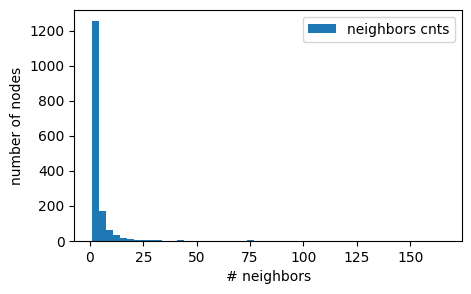

In [8]:
# 统计节点邻居数量的分布情况
neighbors_cnts = [loc[1] - loc[0] for node,loc in vertex_edge_loc.items()]
fig = plt.figure(figsize=(5, 3))
# x 轴用对数刻度
plt.hist(neighbors_cnts, bins=50, label='neighbors cnts')
plt.xlabel('# neighbors')
plt.ylabel('number of nodes')
plt.legend()

在处理图数据时，我们有两种常用方案，**全图处理**和**子图采样**

**(1) 全图处理方案**

**全图处理适用于处理规模不太大的图数据**，这样一张完整的图信息（包含图连接关系，以及节点、边上的特征）能够**一次性加载到内存中进行计算**

现在**图中的节点、以及图中的边都是采用节点名称来表示的**，这**不便于在之后的计算中通过索引快速访问所需要的节点、以及连接节点的边，节点的邻居**，因此，我们还需要进一步对图的表示做一些调整：
* 我们为每个节点 `node` 分配一个索引 `node_idx` ，从 `0, 1, 2, ..` 开始编号
* 将 `edges` 中保存的边的连接从 `node1 <- node2` 变为 `node1_idx <- node2_idx`
* 用一个张量 `neighbors_idx` 存储每个节点的邻居索引
  * 第 `i` 行存放了节点索引为 `i` 的邻居节点的索引
  * 由于每个节点的邻居数量不同，我们可以选取一个 `num_neighbors` 参数
    * 小于 `num_neighbors` 就用 0 填充，邻居数超过 `num_neighbors` 的随机采样 `num_neighbors` 个邻居截断
    * 与文本任务类似，我们可以用 `valid_lens` 来存储每一行的有效邻居个数
  * 张量 `neighbors_idx` 的形状应该是 `(num_nodes, num_neighbors)` 
* 同理，可以用一个张量 `connected_edges_idx` 存储每个节点的相连接的边索引
  * 因为要拼装成张量，同样需要填充和截断，将相连边的数量固定到 `num_neighbors`
  * 这可以帮助我们快速访问到相连接的边上的特征

In [9]:
def prepare_graph_info_cora(vertex, edges, num_neighbors : int=25):
    """
    Parameters
    ----------
    vertex : list
        节点列表
    edges : list
        边列表，每个元素为 (node1, node2, edge_feat)
    num_neighbors : int
        每个节点的采样或填充的邻居数量
    """
    # 为每个节点设置索引
    vertex_idx = {}
    for i,node in enumerate(vertex):
        vertex_idx[node] = i

    # 将边的连接关系转换为其索引的表示
    edges_idx = [(vertex_idx[edge[0]], vertex_idx[edge[1]], edge[2]) for edge in edges]
    # 进行排序，先按照第一个节点索引排序，再按照第二个节点索引排序
    edges_idx = sorted(edges_idx, key=lambda x: (x[0], x[1]))

    # 用列表存储每个节点的邻居在 edges_idx 中的起始位置
    neighbors = [[-1, -1] for _ in range(len(vertex))]
    for i,(node1,_,_) in enumerate(edges_idx):
        if neighbors[node1][0] == -1:
            neighbors[node1][0] = i
        neighbors[node1][1] = i + 1

    # 为每个节点构造邻居节点的索引，相连接的边的索引
    # 邻居数小于 num_neighbors 的节点用 0 填充
    # 邻居数大于 num_neighbors 的节点通过随机采样来截断
    # valid_len 保存每个节点的有效邻居数
    neighbors_idx = [[0] * num_neighbors for _ in range(len(vertex))]
    connected_edges_idx = [[0] * num_neighbors for _ in range(len(vertex))]
    valid_lens = [0] * len(vertex)

    for i,(start,end) in enumerate(neighbors):
        # 获取节点的邻居节点索引
        node_neighbors_idx = [edge[1] for edge in edges_idx[start:end]]
        valid_lens[i] = min(len(node_neighbors_idx), num_neighbors) # 记录节点的有效邻居数

        if end - start > num_neighbors:
            # 邻居数大于 num_neighbors 的节点通过随机采样来截断
            connected_edges_idx[i] = np.random.choice(list(range(start,end)), num_neighbors, replace=False)
            neighbors_idx[i] = [edges_idx[idx][1] for idx in connected_edges_idx[i]]
        else:
            # 邻居数小于 num_neighbors 的节点用 0 填充
            neighbors_idx[i][:end-start] = node_neighbors_idx[:]
            connected_edges_idx[i][:end-start] = list(range(start, end))
    
    return vertex_idx, edges_idx, neighbors_idx, connected_edges_idx, valid_lens

In [10]:
vertex_idx, edges_idx, neighbors_idx, connected_edges_idx, valid_lens \
    = prepare_graph_info_cora(vertex, edges, num_neighbors=25)

现在，给定节点索引，我们就嫩通过 `tf.gather` 快速获取它们的**邻居节点索引，相连的边的索引，以及有效邻居个数**

In [12]:
nodes_idx = [0, 10, 100]
print("邻居节点索引：", tf.gather(neighbors_idx, nodes_idx))
print("相连接的边的索引：", tf.gather(connected_edges_idx, nodes_idx))
print("有效邻居数：", tf.gather(valid_lens, nodes_idx))

邻居节点索引： tf.Tensor(
[[   8  435  544    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 265  758 1611    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(3, 25), dtype=int32)
相连接的边的索引： tf.Tensor(
[[  0   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [271 272 273   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]], shape=(3, 25), dtype=int32)
有效邻居数： tf.Tensor([3 0 3], shape=(3,), dtype=int32)


在构造 **GNN 层中进行消息传递时，需要收集邻居节点的特征表达**，这也会变得非常容易

In [13]:
# 收集来自邻居节点的特征
tf.gather(vertex_feat, tf.gather(neighbors_idx, nodes_idx)).shape

TensorShape([3, 25, 1433])

此时**一个 GNN 层接收下面几个输入**：
* 关于**图的特征部分**：
  * `vertex_feat`：节点特征张量，形状 `(num_nodes, num_feats)`
  * `edges_feat`：边特征张量，形状 `(num_edges, num_feats)`
  * `graph_feat`：全局图特征张量，形状 `(num_feats, )` 或者 `(1, num_feats)`
    * 如果**没有全图特征张量**，但在 GNN 中需要使用全局特征张量时，可以用图中节点特征向量的均值做初始化
* 关于**图的结构部分**：
  * `edges_idx`：边的连接关系，对应两端的节点索引，形状 `(num_edges, 2)`
  * `neighbors_idx`：邻居节点索引张量，形状 `(num_nodes, num_neighbors)`
  * `connected_edges_idx`：相连的边索引张量，形状 `(num_nodes, num_neighbors)`
  * `valid_lens`：有效邻居个数，形状 `(num_nodes, )`

最后，我们将以上的功能包装，创建 `Cora` 节点类型任务的数据集
* 我们可以将所有节点划分为训练集、验证集两部分

In [28]:
def load_cora_nodetask_data(path : str, num_neighbors : int=25, test_size : float=0.4):
    from sklearn.model_selection import train_test_split

    # 加载 cora 数据集
    vertex, vertex_feat, vertex_class, edges, vertex_edge_loc, class_map = load_cora(path=path)
    # 构造全图信息
    vertex_idx, edges_idx, neighbors_idx, connected_edges_idx, valid_lens \
        = prepare_graph_info_cora(vertex, edges, num_neighbors=num_neighbors)

    # 从 edges_idx 中获取边的特征
    edges_feat = [edge[2] for edge in edges_idx]
    edges_idx = [(edge[0], edge[1]) for edge in edges_idx]

    # 构造图，并将所有信息转换为张量
    graph = {
        # 图上的特征
        'vertex_feat': tf.constant(vertex_feat, dtype=tf.int32),
        'edges_feat': None, # cora 数据集没有边的特征
        'graph_feat': None, # cora 数据集没有图的特征
        # 图的连接信息
        'vertex_idx': vertex_idx, # 节点名称到索引的映射
        'edges_idx': tf.constant(edges_idx, dtype=tf.int32),
        'neighbors_idx': tf.constant(neighbors_idx, dtype=tf.int32),
        'connected_edges_idx': tf.constant(connected_edges_idx, dtype=tf.int32),
        'valid_lens': tf.constant(valid_lens, dtype=tf.int32),
    }
    # 节点的标签
    node_labels = tf.constant(vertex_class, dtype=tf.int32)

    # 切分训练集和验证集节点
    train_nodes, valid_nodes = train_test_split(list(range(len(vertex))), test_size=test_size, random_state=42)

    return graph, node_labels, train_nodes, valid_nodes, class_map

In [29]:
graph, node_labels, train_nodes, valid_nodes, class_map =\
    load_cora_nodetask_data(path='../source/data/graph/cora/', num_neighbors=25)

----

**(2) 子图采样方案**

当**图的规模很大时（例如超过百万节点，千万条边）**，一次性将整个图的信息加载到内存并进行计算可能是不可行的（**内存溢出**或**计算缓慢**），这时我们可以采用一种叫做**子图采样**的策略，**将全图以每个节点为中心，拆散为独立的子图，然后在每个子图上进行 GNN 模型的学习**

下面是一种**从每个节点出发实现子图采样**的步骤大致如下：
* 首先**以每个节点为中心**，开始将其周围的图结构信息收集，构成以节点为中心的子图，**每张子图与每个节点一一对应**，因此，我们可以用节点的索引作为子图的索引
* 在考虑所要收集的子图规模时，通常考虑两个超参数：**跳数** $k$ 和 **邻居个数** `num_neighbors`
  * 我们以节点为中心，递归地将周围邻居的连接信息加入子图，**直到** $k$ **跳的连接距离**
  * 在构造子图时，我们会限制 `num_neighbors`，**邻居数超过** `num_neighbors` **的子图会做随机采样**
* 以这种方式采样后，**子图的数量等于全图中节点的数量**

下面是子图采样的示意图

<img src="../source/Chap8/子图采样.png" width=1000>

子图采样后，**每个子图的学习是独立进行的，子图与子图之间没有连接关系**
* 这带来的好处是，每个**节点的计算被限制在** $k$ **跳范围的子图上**，减少了全图信息传递所需的计算量，对全图做子图采样拆分后，也使得计算上可以利用批量处理的方式高效进行
* 带来的缺点也很明显，我们**限制了每个节点能够进行通信的范围**，且子图之间是没有信息交互的，因此无论有多少层 GNN 特征提取层，**节点间的信息传递距离也无法超过子图采样时指定的跳数**
  * 但在大部分的图学习实践中，往往**对节点推断最有帮助的信息都来自直接与它相连的邻居**
  * 因此，子图采样虽然限制了模型性能的上限，但对于大部分任务，不会对性能造成灾难性的影响

下面的函数 `node_subgraph_sampling_cora()` 用于在 `Cora` 数据集上实现子图采样
* 在确定每个子图的结构和信息后，我们在内部调用了上面的函数 `prepare_graph_info_cora`，从而**为每个子图创建节点索引、边索引、邻居索引、相连的边的索引**、并将其填充或截断到固定到固定的邻居数量 `num_neighbors`
* 每个**子图所包含的节点数量是不同的**，为了能够**把每个子图的这些特征和信息拼接为张量**，我们需要**进行填充**
  * 让有关节点的张量具有形状 `(num_graph, num_sub_nodes,...)`，有关边的张量具有形状 `(num_graph, num_sub_edges,...)`
  * `num_sub_nodes` 和 `num_sub_edges` 可以选择**所有子图中节点数量和边数量的最大值**
  * 我们可以用全 0 向量来做填充，然后用 `valid_nodes` 和 `valid_edges` 来**记录每张子图的有效节点数和有效边数**

In [79]:
def node_subgraph_sampling_cora(vertex, edges, vertex_feat, vertex_edge_loc, 
                                k_hops : int=1, num_neighbors : int=20):
    subgraph = {
        "vertex_idx": [],
        "edges_idx": [],
        "vertex_feat": [],
        "neighbors_idx": [],
        "connected_edges_idx": [],
        "valid_lens": []
    }

    # 为每个节点设置索引
    vertex_idx = {}
    for i,node in enumerate(vertex):
        vertex_idx[node] = i

    # 依次以每个节点为中心，采样其 k_hops 邻居构成子图
    for i,node in enumerate(vertex):
        # 创建该子图的节点索引列表
        sub_vertex = [node]
        # 创建该子图的边索引列表
        sub_edges = []

        # 该子图的节点特征
        sub_vertex_feat = [vertex_feat[i]]

        # 递归地采样 k_hops 邻居
        end = 0
        for _ in range(k_hops):
            start, end = end, len(sub_vertex)
            for j in range(start, end):
                node_ = sub_vertex[j] # 当前处理的节点
                
                # 获取节点的邻居节点
                l, r = vertex_edge_loc.get(node_, [-1, -1])

                # 如果邻居数超过 num_neighbors，则随机采样 num_neighbors 个邻居
                neighbors_list = list(range(l,r))
                if len(neighbors_list) > num_neighbors:
                    neighbors_list = np.random.choice(neighbors_list, num_neighbors, replace=False)

                for idx in neighbors_list:
                    # edges[idx][1] 是节点 node_ 的邻居节点
                    from_node = edges[idx][1]

                    # 防止重复添加节点
                    if from_node not in sub_vertex:
                        # 添加节点，以及节点的特征
                        sub_vertex.append(from_node)
                        sub_vertex_feat.append(vertex_feat[vertex_idx[from_node]])

                # 获取节点相连的边
                for idx in neighbors_list:
                    sub_edges.append(edges[idx])
        
        # 为子图中的节点重新设置索引
        sub_vertex_idx = {}
        for i,node in enumerate(sub_vertex):
            sub_vertex_idx[node] = i
        
        # 将节点 node 转换为其索引
        sub_edges_idx = [(sub_vertex_idx[edge[0]], sub_vertex_idx[edge[1]], edge[2]) for edge in sub_edges]
        
        # 创建邻居和相连边的索引
        sub_vertex_idx, sub_edges_idx, sub_neighbors, sub_connected_edges_idx, sub_valid_lens\
            = prepare_graph_info_cora(sub_vertex, sub_edges, num_neighbors=num_neighbors)
        
        # 添加到子图列表中
        subgraph["vertex_feat"].append(sub_vertex_feat)
        subgraph["vertex_idx"].append(sub_vertex_idx)
        subgraph["edges_idx"].append(sub_edges_idx)
        subgraph["neighbors_idx"].append(sub_neighbors)
        subgraph["connected_edges_idx"].append(sub_connected_edges_idx)
        subgraph["valid_lens"].append(sub_valid_lens)

    # 进行填充，使节点信息具有形状 (num_graph, num_sub_nodes, ...)
    # 边信息具有形状 (num_graph, num_sub_edges, ...)
    num_sub_nodes = max([len(x) for x in subgraph["vertex_idx"]])
    num_sub_edges = max([len(x) for x in subgraph["edges_idx"]])
    valid_nodes, valid_edges = [], []
    num_graph = len(subgraph["vertex_idx"])

    # 节点信息填充
    for i in range(num_graph):
        num_nodes = len(subgraph["vertex_idx"][i])
        valid_nodes.append(num_nodes)

        subgraph["vertex_feat"][i] += [[0] * len(vertex_feat[0]) for _ in range(num_sub_nodes - num_nodes)]
        subgraph["neighbors_idx"][i] += [[0] * num_neighbors for _ in range(num_sub_nodes - num_nodes)]
        subgraph["connected_edges_idx"][i] += [[0] * num_neighbors for _ in range(num_sub_nodes - num_nodes)]
        subgraph["valid_lens"][i] += [0] * (num_sub_nodes - num_nodes)
    
    # 边信息填充
    for i in range(num_graph):
        num_edges = len(subgraph["edges_idx"][i])
        valid_edges.append(num_edges)

        subgraph["edges_idx"][i] += [(0, 0, None) for _ in range(num_sub_edges - num_edges)]

    # 记录有效节点数和有效边数
    subgraph["valid_nodes"] = valid_nodes
    subgraph["valid_edges"] = valid_edges

    return subgraph

In [80]:
# 做 1跳 子图采样
subgraph = node_subgraph_sampling_cora(vertex, edges,vertex_feat, vertex_edge_loc, k_hops=1, num_neighbors=20)

num_valid_nodes = subgraph["valid_nodes"][0] # 该子图的有效节点数
num_valid_edges = subgraph["valid_edges"][0] # 该子图的有效边数

print("第一个子图的有效节点数：",num_valid_nodes)
print("第一个子图的有效边数：",num_valid_edges)
# 打印信息
print("第一个子图的节点索引：",subgraph["vertex_idx"][0])
print("第一个子图的边连接关系：",subgraph["edges_idx"][0][:num_valid_edges])
print("第一个子图的节点特征：\n",tf.constant(subgraph["vertex_feat"][0][:num_valid_nodes]))
print("第一个子图的邻居节点索引：\n",tf.constant(subgraph["neighbors_idx"][0][:num_valid_nodes]))
print("第一个子图的相连边索引：\n",tf.constant(subgraph["connected_edges_idx"][0][:num_valid_nodes]))
print("第一个子图的有效邻居数：\n",tf.constant(subgraph["valid_lens"][0][:num_valid_nodes]))

第一个子图的有效节点数： 4
第一个子图的有效边数： 3
第一个子图的节点索引： {31336: 0, 31349: 1, 686532: 2, 1129442: 3}
第一个子图的边连接关系： [(0, 1, None), (0, 2, None), (0, 3, None)]
第一个子图的节点特征：
 tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(4, 1433), dtype=int32)
第一个子图的邻居节点索引：
 tf.Tensor(
[[1 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(4, 20), dtype=int32)
第一个子图的相连边索引：
 tf.Tensor(
[[0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(4, 20), dtype=int32)
第一个子图的有效邻居数：
 tf.Tensor([3 0 0 0], shape=(4,), dtype=int32)


使用**子图采样的 GNN 接收下面几个输入**：
* 关于**图的特征部分**：
  * `subgraph[vertex_feat]`：节点特征张量，形状 `(num_graph, num_sub_nodes, num_feats)`
  * `subgraph[edges_feat]`：边特征张量，形状 `(num_graph, num_sub_edges, num_feats)`
  * `subgraph[graph_feat]`：全局图特征张量，形状 `(num_graph, num_feats)`
    * 与全图处理的思路类似，如果**没有全图特征张量**，可以用每个子图中各节点特征向量的均值做初始化
* 关于**图的结构部分**：
  * `subgraph[edges_idx]`：边的连接关系，对应两端的节点索引，形状 `(num_graph, num_sub_edges, 2)`
  * `subgraph[neighbors_idx]`：邻居节点索引张量，形状 `(num_graph, num_sub_nodes, num_neighbors)`
  * `subgraph[connected_edges_idx]`：相连的边索引张量，形状 `(num_graph, num_sub_nodes, num_neighbors)`
  * `subgraph[valid_lens]`：有效邻居个数，形状 `(num_graph, num_sub_nodes)`
  * `subgraph[valid_nodes]`：每个子图的有效节点数，形状 `(num_graph, )`
  * `subgraph[valid_edegs]`：每个子图的有效边数，形状 `(num_graph, )`

In [78]:
# (num_graph, num_sub_nodes, num_feat)
print("子图特征形状：",tf.constant(subgraph["vertex_feat"]).shape) 
# (num_graph, num_sub_nodes, num_neighbors)
print("子图邻居节点索引形状：",tf.constant(subgraph["neighbors_idx"]).shape) 

子图特征形状： (2708, 21, 1433)
子图邻居节点索引形状： (2708, 21, 20)


----

### **练习**

----